In [30]:
# Load the Important Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from arch import arch_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [31]:
# Set seaborn style
sns.set_theme(style="whitegrid")

In [32]:
# Load the Dataset 
df = pd.read_csv("BTC-USD.csv")

# Dataset Overview

In [33]:
# Display the first few rows of the dataset
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,10-10-2014,364.687012,375.066986,352.963013,361.562012,361.562012,43665700.0
1,11-10-2014,361.362000,367.191010,355.950989,362.299011,362.299011,13345200.0
2,12-10-2014,362.605988,379.433014,356.144012,378.549011,378.549011,17552800.0
3,13-10-2014,377.920990,397.226013,368.897003,390.414001,390.414001,35221400.0
4,14-10-2014,391.691986,411.697998,391.324005,400.869995,400.869995,38491500.0


In [34]:
# Display the information of the Dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3566 entries, 0 to 3565
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       3566 non-null   object 
 1   Open       3566 non-null   float64
 2   High       3566 non-null   float64
 3   Low        3566 non-null   float64
 4   Close      3566 non-null   float64
 5   Adj Close  3566 non-null   float64
 6   Volume     3566 non-null   float64
dtypes: float64(6), object(1)
memory usage: 195.1+ KB


In [35]:
# Display the description of the Dataset
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,3566.000000,3566.000000,3566.000000,3566.000000,3566.000000,3.566000e+03
mean,17130.767783,17521.648929,16713.151782,17146.361191,17146.361191,1.746206e+10
std,18911.211338,19338.260241,18441.412465,18920.806425,18920.806425,1.917847e+10
min,176.897003,211.731003,171.509995,178.102997,178.102997,5.914570e+06
25%,1164.660034,1186.739960,1126.907532,1166.924988,1166.924988,2.928932e+08
50%,8940.442871,9202.832520,8790.986328,8987.823243,8987.823243,1.363268e+10
75%,28084.279785,28531.553713,27534.169433,28148.959470,28148.959470,2.805912e+10
max,73079.375000,73750.070310,71334.093750,73083.500000,73083.500000,3.509680e+11


# Handling Same Columns

In [36]:
# Check for same values in 'Close' and 'Adj Close' column
(df['Close'] - df['Adj Close']).sum()

0.0

In [37]:
# Drop 'Adj Close' as it is same as 'Close'
df.drop(columns=['Adj Close'], inplace=True)

# Handling Duplicate Values

In [38]:
# Displaying the number of duplicate rows
df.duplicated().sum()

0

In [39]:
# Getting the shape of the dataframe
df.shape

(3566, 6)

# Handling Missing Values

In [40]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing Values:")
print(missing_values)

Missing Values:
Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


In [41]:
# Getting the shape of the dataframe
df.shape

(3566, 6)

# Handling Date Formatting

In [42]:
# # Formatting the date column into Datetime format
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

# Set 'Date' as index
df.set_index('Date', inplace=True)

# # Sort by Date index
df.sort_index(inplace=True)

# Show dataset
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2014-10-10,364.687012,375.066986,352.963013,361.562012,43665700.0
2014-10-11,361.362000,367.191010,355.950989,362.299011,13345200.0
2014-10-12,362.605988,379.433014,356.144012,378.549011,17552800.0
2014-10-13,377.920990,397.226013,368.897003,390.414001,35221400.0
2014-10-14,391.691986,411.697998,391.324005,400.869995,38491500.0


In [43]:
# Getting the shape of the dataframe
df.shape

(3566, 5)

# Weekly Resampling of Data

In [44]:
# Weekly Resampling
df_weekly = df.resample('W').mean()

# Display dataset  
df_weekly.head()

,Open,High,Low,Close,Volume
Date,,,,,
2014-10-12,362.885000,373.897003,355.019338,367.470011,2.485457e+07
2014-10-19,389.010284,397.790427,380.410575,390.479854,2.241458e+07
2014-10-26,372.202999,377.111572,362.556431,367.316428,1.624169e+07
2014-11-02,344.360574,349.283713,335.960850,340.209289,1.529653e+07
2014-11-09,337.174146,346.499145,335.407144,342.569859,1.668478e+07


In [45]:
# Getting the shape of the dataframe
df_weekly.shape

(510, 5)

# Feature Engineering

In [46]:
# Feature engineering
df_weekly['Return'] = df_weekly['Close'].pct_change()
df_weekly['MA4'] = df_weekly['Close'].rolling(window=4).mean()
df_weekly['MA12'] = df_weekly['Close'].rolling(window=12).mean()
df_weekly['Volatility'] = df_weekly['Close'].rolling(window=4).std()
df_weekly['Lag1'] = df_weekly['Close'].shift(1)
df_weekly['Lag2'] = df_weekly['Close'].shift(2)

# Drop rows with any NaN values
df_weekly.dropna(inplace=True)

# Display dataset  
df_weekly.head()

,Open,High,Low,Close,Volume,Return,MA4,MA12,Volatility,Lag1,Lag2
Date,,,,,,,,,,,
2014-12-28,324.664433,329.739720,318.382429,324.146572,1.530536e+07,-0.001406,344.132285,359.826024,24.861067,324.602997,351.792712
2015-01-04,310.262857,313.417568,299.736141,302.594003,2.047920e+07,-0.066490,325.784071,354.419690,20.151964,324.146572,324.602997
2015-01-11,280.600146,288.237435,274.653146,281.316140,2.346307e+07,-0.070318,308.164928,345.322714,20.635856,302.594003,324.146572
2015-01-18,221.612145,235.065432,203.237858,214.185710,5.187317e+07,-0.238630,280.560606,332.561821,47.579423,281.316140,302.594003
2015-01-25,225.235286,233.557857,221.317858,231.560429,2.702364e+07,0.081120,257.414071,323.507749,41.431217,214.185710,281.316140


In [47]:
# Getting the shape of the dataframe
df_weekly.shape

(499, 11)

# Analysis of Different Features

Bitcoin Price Movements Over Time (Open, High, Low, Close) - (Weekly)

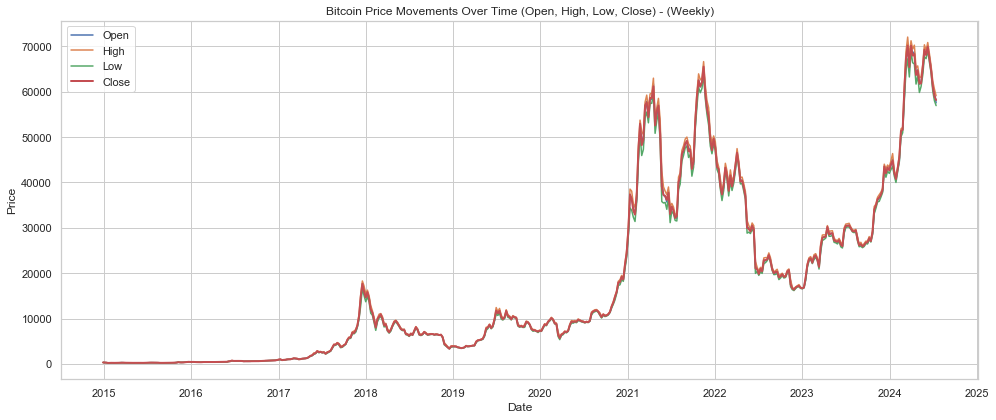

In [48]:
# Line Plots for Price Movements (weekly)
plt.figure(figsize=(14, 6))
plt.plot(df_weekly.index, df_weekly['Open'], label='Open')
plt.plot(df_weekly.index, df_weekly['High'], label='High')
plt.plot(df_weekly.index, df_weekly['Low'], label='Low')
plt.plot(df_weekly.index, df_weekly['Close'], label='Close', linewidth=2)
plt.title('Bitcoin Price Movements Over Time (Open, High, Low, Close) - (Weekly)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Bitcoin Trading Volume Over Time (Weekly)

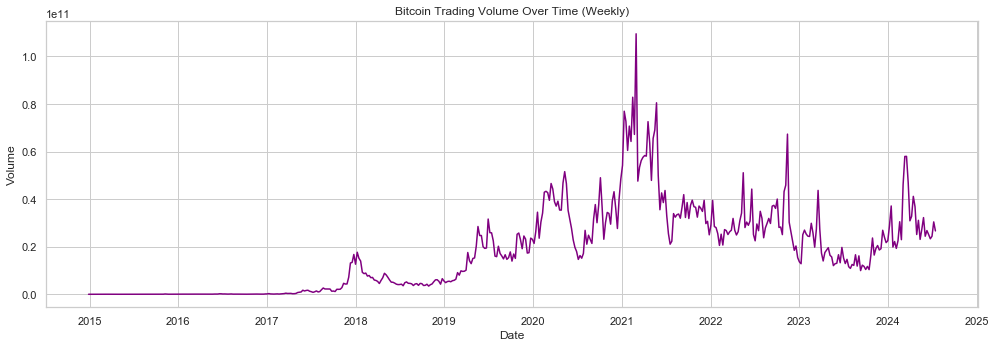

In [49]:
# Volume Over Time (weekly)
plt.figure(figsize=(14, 5))
plt.plot(df_weekly.index, df_weekly['Volume'], color='purple')
plt.title('Bitcoin Trading Volume Over Time (Weekly)')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.grid(True)
plt.tight_layout()
plt.show()

Bitcoin Close Price with Moving Averages (Weekly)

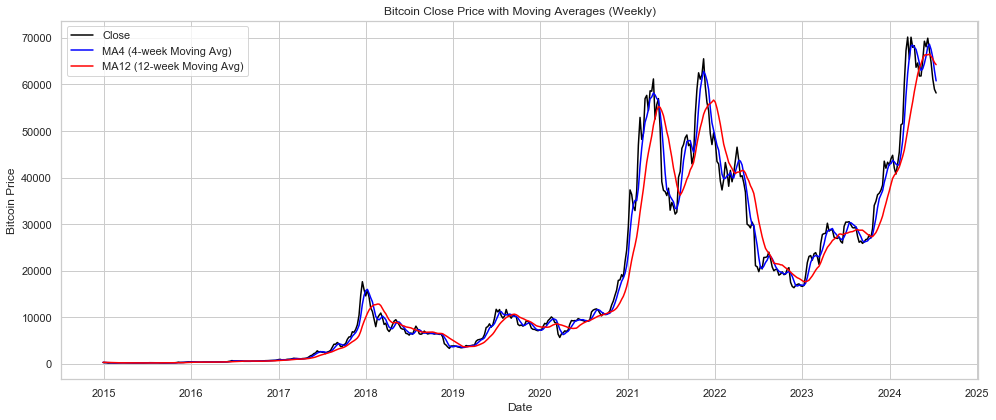

In [50]:
# Moving Averages Visualization (Close, MA4, MA12) - (weekly)
plt.figure(figsize=(14, 6))
plt.plot(df_weekly.index, df_weekly['Close'], label='Close', color='black')
plt.plot(df_weekly.index, df_weekly['MA4'], label='MA4 (4-week Moving Avg)', color='blue')
plt.plot(df_weekly.index, df_weekly['MA12'], label='MA12 (12-week Moving Avg)', color='red')
plt.title('Bitcoin Close Price with Moving Averages (Weekly)')
plt.xlabel('Date')
plt.ylabel('Bitcoin Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Bitcoin 4-Week Rolling Volatility Over Time (Weekly)

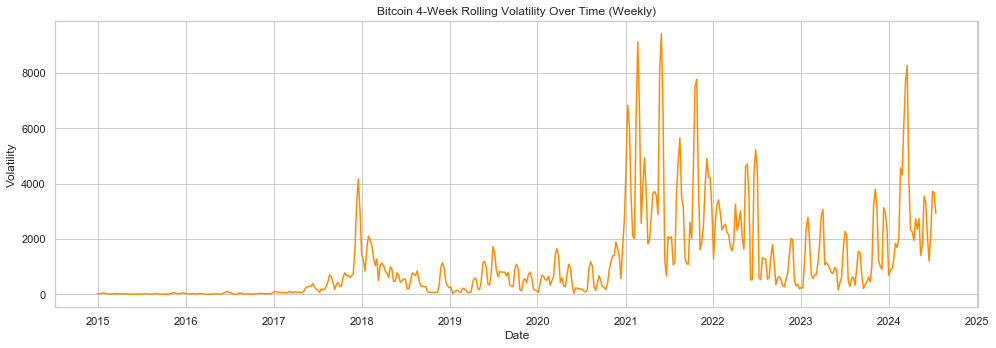

In [51]:
# Rolling Volatility Over Time (weekly)
plt.figure(figsize=(14, 5))
plt.plot(df_weekly.index, df_weekly['Volatility'], color='darkorange')
plt.title('Bitcoin 4-Week Rolling Volatility Over Time (Weekly)')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.grid(True)
plt.tight_layout()
plt.show()

Bitcoin Trading Returns Over Time (Weekly)

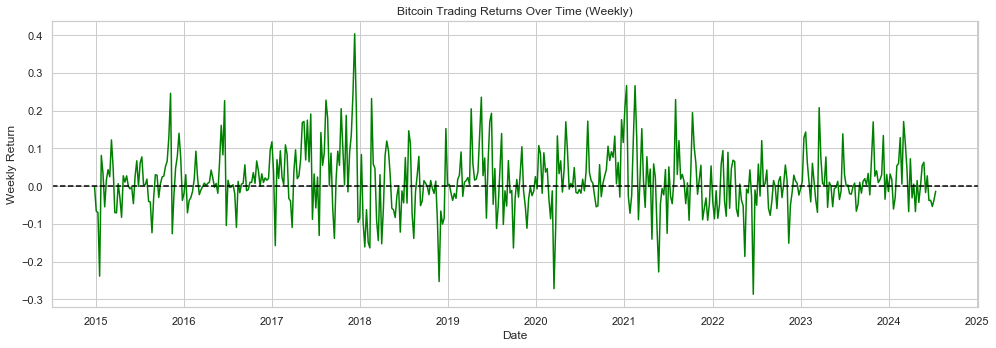

In [52]:
# Return Over Time (weekly)
plt.figure(figsize=(14, 5))
plt.plot(df_weekly.index, df_weekly['Return'], color='green')
plt.axhline(0, color='black', linestyle='--')
plt.title('Bitcoin Trading Returns Over Time (Weekly)')
plt.xlabel('Date')
plt.ylabel('Weekly Return')
plt.grid(True)
plt.tight_layout()
plt.show()

Scatter Plots of Each Feature vs Close Price

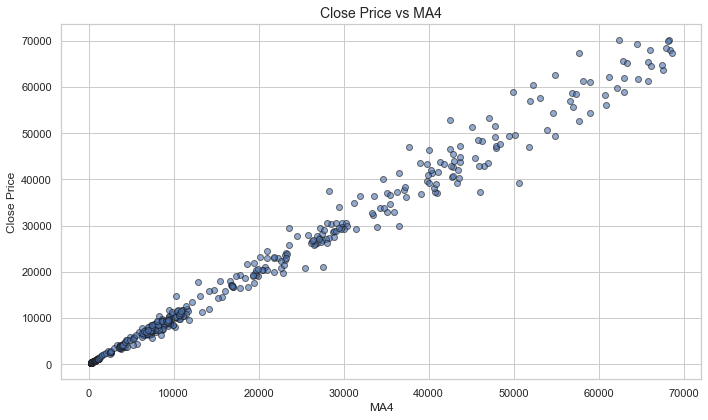

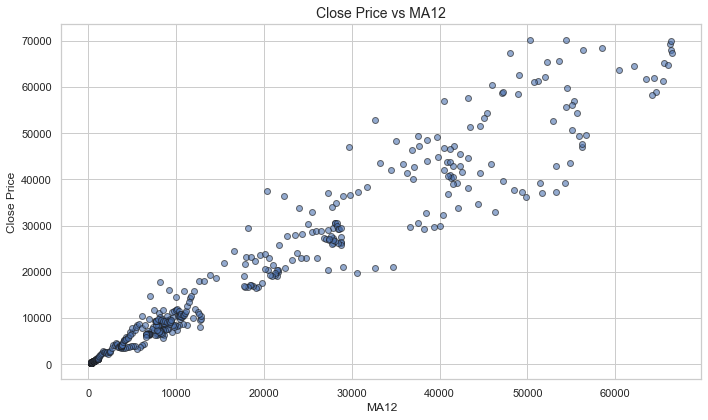

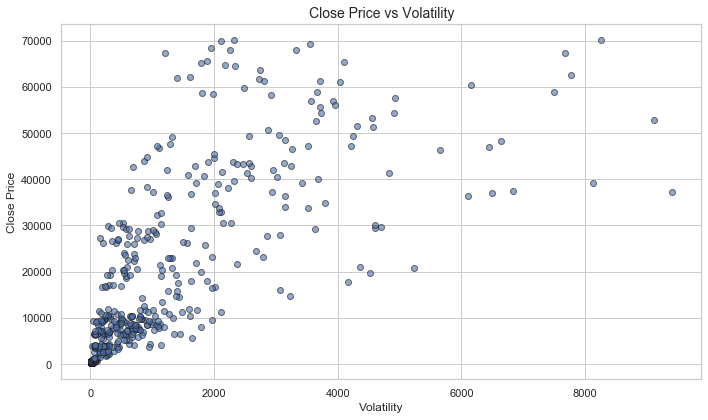

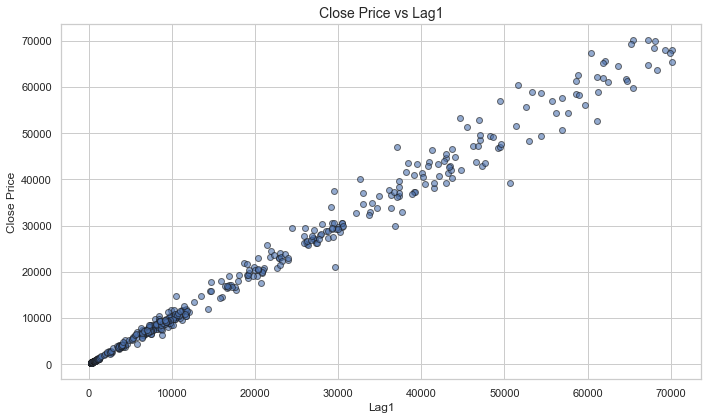

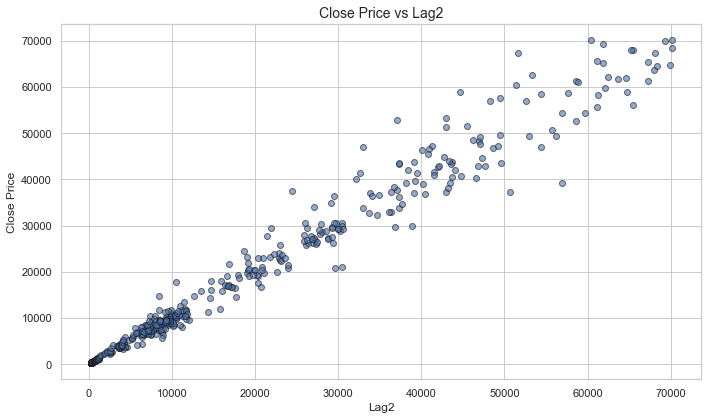

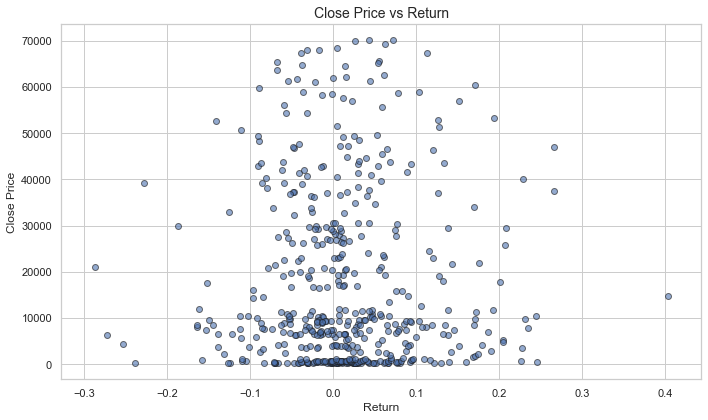

In [ ]:
# Scatter Plots of Each Feature vs Close Price
scatter_features = ['MA4', 'MA12', 'Lag1', 'Lag2', 'Volatility', 'Return']

for feature in scatter_features:
    plt.figure(figsize=(10, 6))
    plt.scatter(df_weekly[feature], df_weekly['Close'], alpha=0.6, edgecolors='k')
    plt.title(f'Close Price vs {feature}', fontsize=14)
    plt.xlabel(feature, fontsize=12)
    plt.ylabel('Close Price', fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Correlation Matrix

Correlation with 'Close':
 Close         1.000000
High          0.999884
Open          0.999855
Low           0.999842
Lag1          0.994710
MA4           0.994114
Lag2          0.986989
MA12          0.969405
Volatility    0.732917
Volume        0.689996
Return       -0.007710
Name: Close, dtype: float64


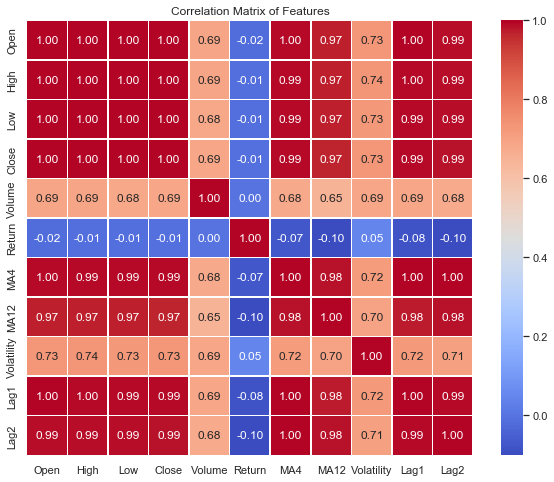

Important features related to 'Close' (correlation > 0.5):
 ['Close', 'High', 'Open', 'Low', 'Lag1', 'MA4', 'Lag2', 'MA12', 'Volatility', 'Volume']


In [54]:
# Calculate correlation between all columns and 'Close'
correlation_matrix = df_weekly.corr()

# Display correlation with 'Close' specifically
close_correlation = correlation_matrix['Close'].sort_values(ascending=False)
print("Correlation with 'Close':\n", close_correlation)

# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix of Features")
plt.show()

# Select columns with high correlation
important_features = close_correlation[close_correlation.abs() > 0.5].index.tolist()

# Display important columns that are highly correlated with 'Close'
print("Important features related to 'Close' (correlation > 0.5):\n", important_features)

# Data Spliting

In [55]:
# Define features and target
features = ['High', 'Open', 'Low', 'Lag1', 'MA4', 'Lag2', 'MA12', 'Volatility', 'Volume']
target = 'Close'

X = df_weekly[features]
y = df_weekly[target]

# 80-20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# Model Training using SARIMA

In [56]:
# SARIMA needs target series only
sarima_train = y_train
sarima_test = y_test

# Fit SARIMA model
sarima_model = SARIMAX(sarima_train, order=(1,1,1), seasonal_order=(1,1,1,52))
sarima_result = sarima_model.fit(disp=False)

# Forecast
sarima_forecast = sarima_result.forecast(steps=len(sarima_test))

In [57]:
# Evaluate Model Performance
sarima_rmse = np.sqrt(mean_squared_error(sarima_test, sarima_forecast))
sarima_mae = mean_absolute_error(sarima_test, sarima_forecast)
sarima_r2_score = r2_score(sarima_test, sarima_forecast)

# Print Evaluation Metrics
print("SARIMA Evaluation:")
print(f"RMSE: {sarima_rmse:.4f}")
print(f"MAE: {sarima_mae:.4f}")
print(f"(R²) Score: {sarima_r2_score:.4f}")

SARIMA Evaluation:
RMSE: 15807.8032
MAE: 13737.0908
(R²) Score: 0.1228


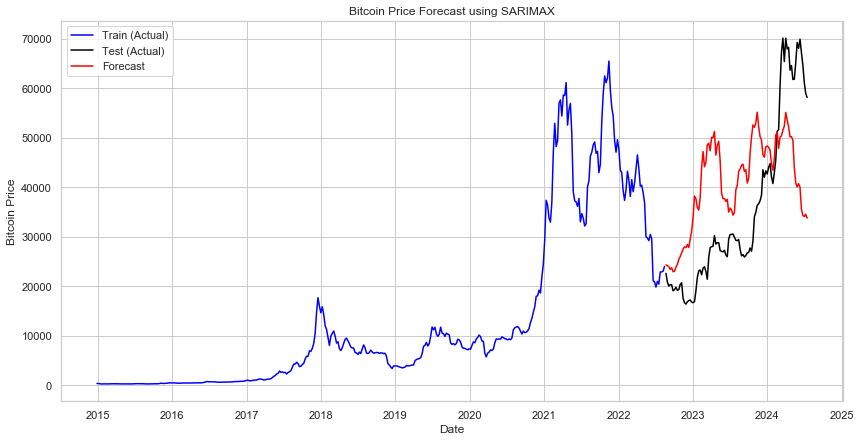

In [58]:
# Plotting
plt.figure(figsize=(14,7))
plt.plot(sarima_train.index, sarima_train, label='Train (Actual)', color='blue')
plt.plot(sarima_test.index, sarima_test, label='Test (Actual)', color='black')
plt.plot(sarima_test.index, sarima_forecast, label='Forecast', color='red')
plt.title('Bitcoin Price Forecast using SARIMAX')
plt.xlabel('Date')
plt.ylabel('Bitcoin Price')
plt.legend()
plt.grid(True)
plt.show()

# Hyperparameter Tuning of SARIMA

In [89]:
# Prepare Data
sarima_data = df_weekly['Close'].copy()

# Log-transform
sarima_data_log = np.log(sarima_data)

# Train-test split (80% train, 20% test)
train_size = int(len(sarima_data_log) * 0.8)
train_log, test_log = sarima_data_log.iloc[:train_size], sarima_data_log.iloc[train_size:]

# Auto ARIMA Model Selection
stepwise_model = auto_arima(train_log,
                            start_p=0, start_q=0,
                            max_p=2, max_q=2,
                            seasonal=True,
                            m=52,
                            start_P=0, start_Q=0,
                            max_P=2, max_Q=2,
                            d=None, D=1,
                            trace=True,
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True)

print(stepwise_model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=-444.965, Time=2.16 sec
 ARIMA(1,1,0)(1,1,0)[52]             : AIC=-580.343, Time=21.76 sec
 ARIMA(0,1,1)(0,1,1)[52]             : AIC=inf, Time=41.94 sec
 ARIMA(1,1,0)(0,1,0)[52]             : AIC=-469.790, Time=0.58 sec
 ARIMA(1,1,0)(2,1,0)[52]             : AIC=-614.365, Time=130.94 sec
 ARIMA(1,1,0)(2,1,1)[52]             : AIC=inf, Time=208.09 sec
 ARIMA(1,1,0)(1,1,1)[52]             : AIC=inf, Time=103.48 sec
 ARIMA(0,1,0)(2,1,0)[52]             : AIC=inf, Time=49.28 sec
 ARIMA(2,1,0)(2,1,0)[52]             : AIC=-612.595, Time=176.61 sec
 ARIMA(1,1,1)(2,1,0)[52]             : AIC=-612.622, Time=156.15 sec
 ARIMA(0,1,1)(2,1,0)[52]             : AIC=-611.461, Time=75.29 sec
 ARIMA(2,1,1)(2,1,0)[52]             : AIC=-610.573, Time=241.81 sec
 ARIMA(1,1,0)(2,1,0)[52] intercept   : AIC=-612.771, Time=154.73 sec

Best model:  ARIMA(1,1,0)(2,1,0)[52]          
Total fit time: 1363.151 seconds
       

In [90]:
# Train SARIMAX Model
sarimax_model = SARIMAX(train_log,
                        order=stepwise_model.order,
                        seasonal_order=stepwise_model.seasonal_order,
                        enforce_stationarity=False,
                        enforce_invertibility=False)

# Fit SARIMA model
sarimax_result = sarimax_model.fit(disp=False)

# Print summary
print(sarimax_result.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                  399
Model:             SARIMAX(1, 1, 0)x(2, 1, 0, 52)   Log Likelihood                 214.936
Date:                            Mon, 28 Apr 2025   AIC                           -421.872
Time:                                    23:25:40   BIC                           -407.933
Sample:                                12-28-2014   HQIC                          -416.256
                                     - 08-14-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2634      0.065      4.067      0.000       0.136       0.390
ar.S.L52      -0.7723      0.058   

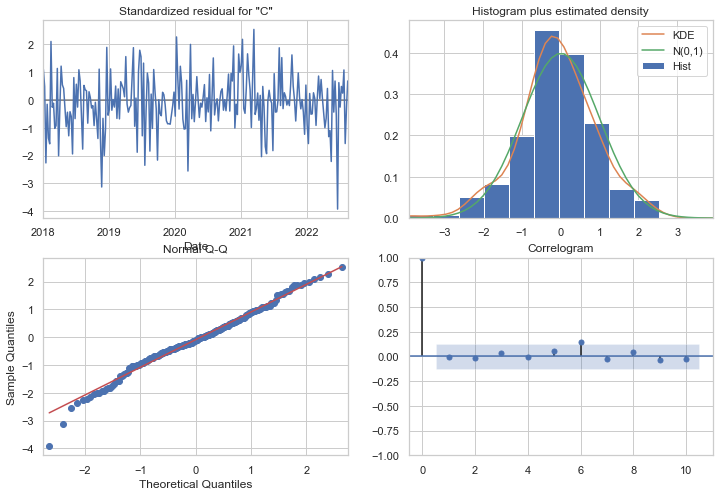

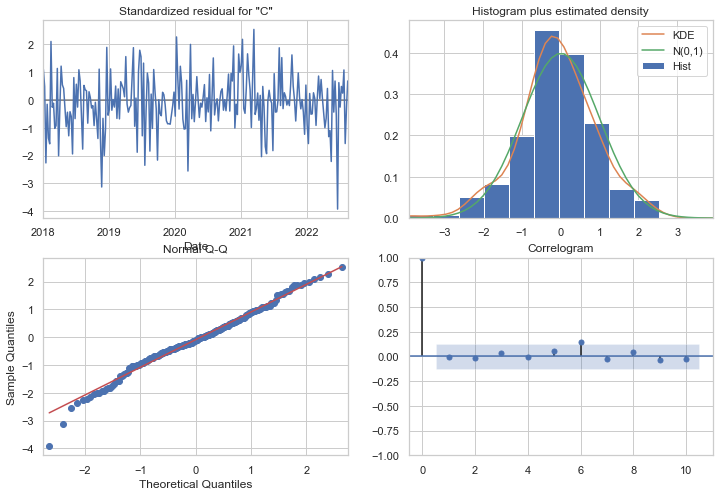

In [91]:
# Plotting diagnostics
sarimax_result.plot_diagnostics(figsize=(12, 8))

In [92]:
# Forecast Test Set
n_forecast = len(test_log)
sarimax_forecast = sarimax_result.get_forecast(steps=n_forecast)
forecast_log_mean = sarimax_forecast.predicted_mean

# Residuals from SARIMAX
residuals_log = sarimax_result.resid

# Fit GARCH on residuals
garch_model = arch_model(residuals_log, vol='Garch', p=1, q=1)
garch_result = garch_model.fit(disp='off')
print(garch_result.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                98.2498
Distribution:                  Normal   AIC:                          -188.500
Method:            Maximum Likelihood   BIC:                          -172.544
                                        No. Observations:                  399
Date:                Mon, Apr 28 2025   Df Residuals:                      398
Time:                        23:25:47   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu            -0.0104  8.449e-03     -1.229      0.219 

c:\Users\eq0024au\anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


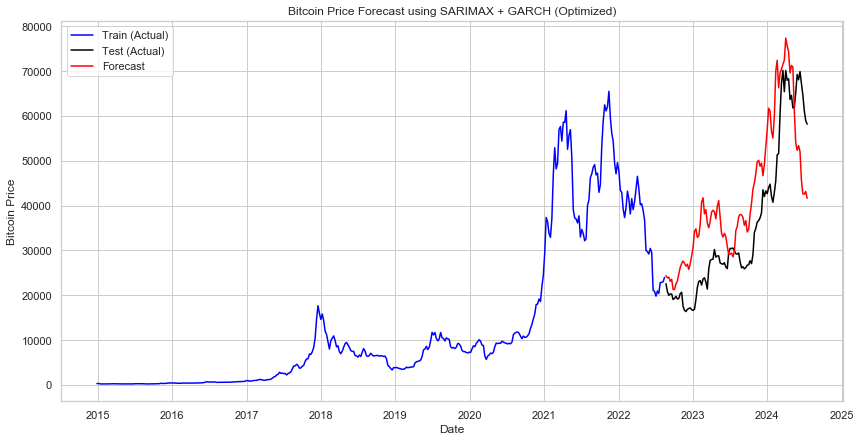

In [93]:
# Forecast GARCH Variance
garch_forecast = garch_result.forecast(horizon=n_forecast)
garch_variance = garch_forecast.variance.values[-1, :]
garch_std = np.sqrt(garch_variance)

# Inverse-log transform predictions
forecast = np.exp(forecast_log_mean)
train_actual = np.exp(train_log)
test_actual = np.exp(test_log)

# Create Confidence Interval Bands
forecast_upper = forecast + garch_std
forecast_lower = forecast - garch_std

# Plotting
plt.figure(figsize=(14,7))
plt.plot(train_actual.index, train_actual, label='Train (Actual)', color='blue')
plt.plot(test_actual.index, test_actual, label='Test (Actual)', color='black')
plt.plot(test_actual.index, forecast, label='Forecast', color='red')
plt.title('Bitcoin Price Forecast using SARIMAX + GARCH (Optimized)')
plt.xlabel('Date')
plt.ylabel('Bitcoin Price')
plt.legend()
plt.grid(True)
plt.show()

In [94]:
# Evaluate Model Performance
best_sarima_rmse = np.sqrt(mean_squared_error(test_actual, forecast))
best_sarima_mae = mean_absolute_error(test_actual, forecast)
best_sarima_r2_score = r2_score(test_actual, forecast)

# Print Evaluation Metrics
print(f"Best SARIMA Evaluation:")
print(f"RMSE: {best_sarima_rmse:.4f}")
print(f"MAE: {best_sarima_mae:.4f}")
print(f"(R²) Score: {best_sarima_r2_score:.4f}")

Best SARIMA Evaluation:
RMSE: 11343.2303
MAE: 9970.4710
(R²) Score: 0.5483


SARIMAX Evaluation and Exclusion:

Applied SARIMAX with log transformation, seasonal modeling, and auto_arima tuning.

Integrated GARCH to capture residual volatility.

Model achieved poor metrics: RMSE ≈ 11,343, MAE ≈ 9,970, R² ≈ 0.55

Failed to capture Bitcoin’s volatility and nonlinear patterns.

Consistently underperformed compared to Random Forest and XGBoost.

SARIMAX was excluded from the final ensemble for lack of predictive reliability.

# Model Training using Random Forest Regressor

In [95]:
# Initialize Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit RF Model
rf_model.fit(X_train, y_train)

# Predictions
rf_pred = rf_model.predict(X_test)

In [96]:
# Evaluate Model Performance
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
rf_mae = mean_absolute_error(y_test, rf_pred)
rf_r2_score = r2_score(y_test, rf_pred)

# Print Evaluation Metrics
print("Random Forest Evaluation:")
print(f"RMSE: {rf_rmse:.4f}")
print(f"MAE: {rf_mae:.4f}")
print(f"(R²) Score: {rf_r2_score:.4f}")

Random Forest Evaluation:
RMSE: 1813.6784
MAE: 1099.3993
(R²) Score: 0.9885


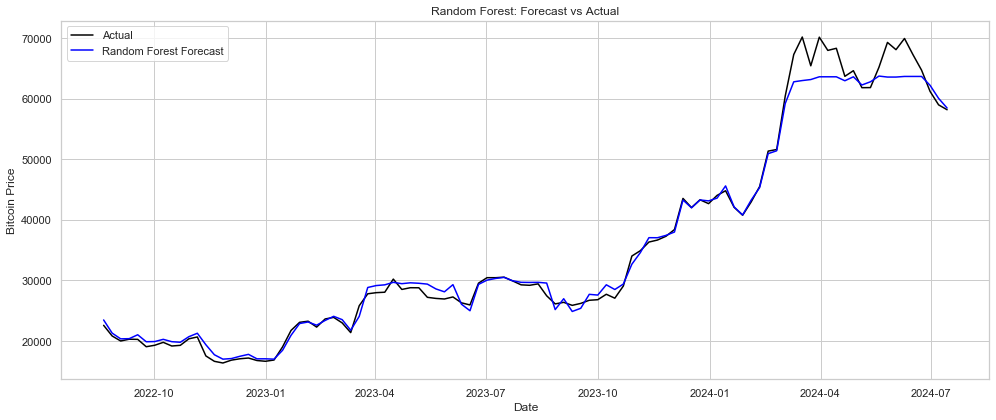

In [97]:
# Plotting
plt.figure(figsize=(14, 6))
plt.plot(y_test.index, y_test, label='Actual', color='black')
plt.plot(y_test.index, rf_pred, label='Random Forest Forecast', color='blue')
plt.title('Random Forest: Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Bitcoin Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Hyperparameter Tuning of Random Forest Regressor

In [98]:
# Initialize Random Forest Regressor
rf = RandomForestRegressor(random_state=42)

# Define parameter grid
param_distributions = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto', 'sqrt']
}

# Define TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)

# RandomizedSearchCV
random_search_rf = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_distributions,
    n_iter=10,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    verbose=1,
    n_jobs=1,
    random_state=42
)

# Fit the model
random_search_rf.fit(X_train, y_train)

# Best estimator
best_rf = random_search_rf.best_estimator_
print("Best Parameters:", random_search_rf.best_params_)

# Predictions
best_rf_pred = best_rf.predict(X_test)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': None}


In [99]:
# Evaluate Model Performance
best_rf_rmse = np.sqrt(mean_squared_error(y_test, best_rf_pred))
best_rf_mae = mean_absolute_error(y_test, best_rf_pred)
best_rf_r2_score = r2_score(y_test, best_rf_pred)

# Print Evaluation Metrics
print("Best Random Forest Evaluation:")
print(f"RMSE: {best_rf_rmse:.4f}")
print(f"MAE: {best_rf_mae:.4f}")
print(f"(R²) Score: {best_rf_r2_score:.4f}")

Best Random Forest Evaluation:
RMSE: 1779.2751
MAE: 1089.1648
(R²) Score: 0.9889


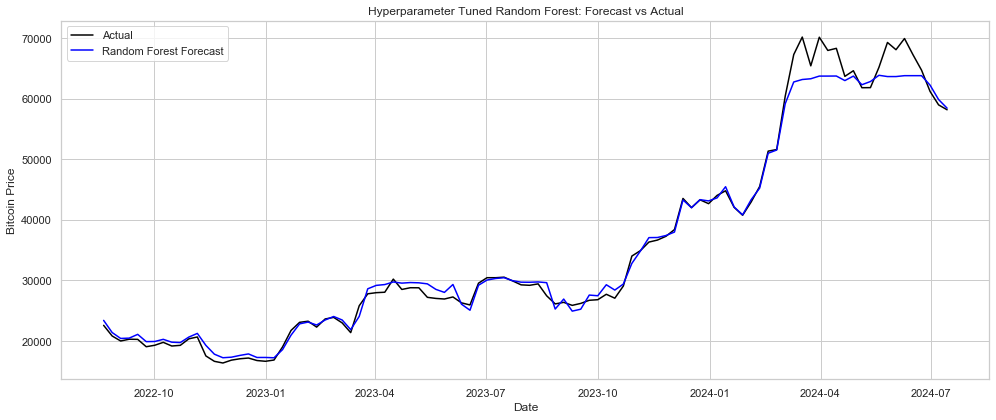

In [100]:
# Plotting
plt.figure(figsize=(14, 6))
plt.plot(y_test.index, y_test, label='Actual', color='black')
plt.plot(y_test.index, best_rf_pred, label='Random Forest Forecast', color='blue')
plt.title('Hyperparameter Tuned Random Forest: Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Bitcoin Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Random Forest Evaluation:

Random Forest tuned using RandomizedSearchCV with TimeSeriesSplit (3 folds).

Best model found with: 150 trees, unlimited depth, ‘auto’ max features, split on 2 samples, minimum 1 sample per leaf.

Achieved strong metrics: RMSE ≈ 1779.28, MAE ≈ 1089.16, R² ≈ 0.9889.

Captured Bitcoin price patterns well after hyperparameter tuning and careful cross-validation.

# Model Training using XGBoost Regressor

In [101]:
# Initialize XGBoost Regressor
xgb_model = XGBRegressor(n_estimators=100, random_state=42)

# Fit XGBoost Model
xgb_model.fit(X_train, y_train)

# Predictions
xgb_pred = xgb_model.predict(X_test)

In [102]:
# Evaluate Model Performance
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
xgb_mae = mean_absolute_error(y_test, xgb_pred)
xgb_r2_score = r2_score(y_test, xgb_pred)

# Print Evaluation Metrics
print("XGBoost Evaluation:")
print(f"RMSE: {xgb_rmse:.4f}")
print(f"MAE: {xgb_mae:.4f}")
print(f"(R²) Score: {xgb_r2_score:.4f}")

XGBoost Evaluation:
RMSE: 1575.6432
MAE: 1141.9183
(R²) Score: 0.9913


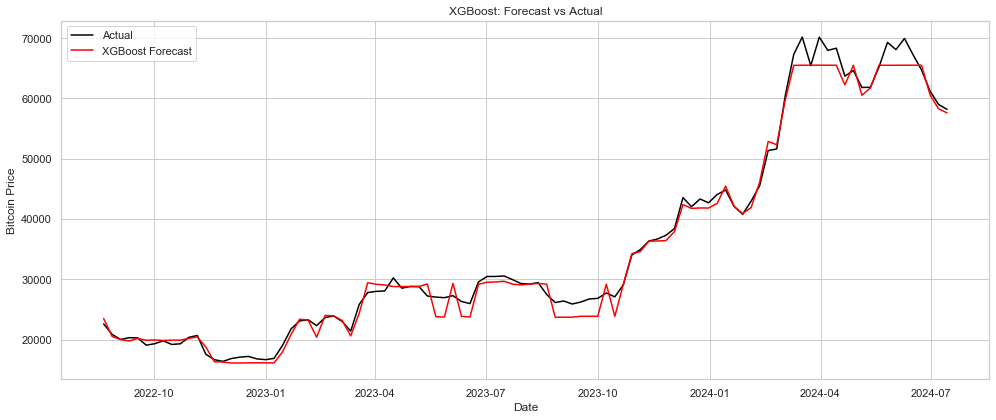

In [103]:
# Plotting
plt.figure(figsize=(14, 6))
plt.plot(y_test.index, y_test, label='Actual', color='black')
plt.plot(y_test.index, xgb_pred, label='XGBoost Forecast', color='red')
plt.title('XGBoost: Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Bitcoin Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Hyperparameter Tuning of XGBoost Regressor

In [104]:
# Initialize XGBoost Regressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Define parameter grid
param_distributions = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3],
    'reg_lambda': [0.1, 1, 10]
}

# Define TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)

# RandomizedSearchCV
random_search_xgb = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=10,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    verbose=1,
    n_jobs=1,
    random_state=42
)

# Fit the model
random_search_xgb.fit(X_train, y_train)

# Best estimator
best_xgb = random_search_xgb.best_estimator_
print("Best Parameters (XGB):", random_search_xgb.best_params_)

# Refit with early stopping on full best model
best_xgb.set_params(early_stopping_rounds=10)

best_xgb.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

# Predictions
best_xgb_pred = best_xgb.predict(X_test)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters (XGB): {'subsample': 1.0, 'reg_lambda': 1, 'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 0.8}


In [105]:
# Evaluate Model Performance
best_xgb_rmse = np.sqrt(mean_squared_error(y_test, best_xgb_pred))
best_xgb_mae = mean_absolute_error(y_test, best_xgb_pred)
best_xgb_r2_score = r2_score(y_test, best_xgb_pred)

# Print Evaluation Metrics
print("Best XGBoost Evaluation:")
print(f"RMSE: {best_xgb_rmse:.4f}")
print(f"MAE: {best_xgb_mae:.4f}")
print(f"(R²) Score: {best_xgb_r2_score:.4f}")

Best XGBoost Evaluation:
RMSE: 1218.6317
MAE: 748.5009
(R²) Score: 0.9948


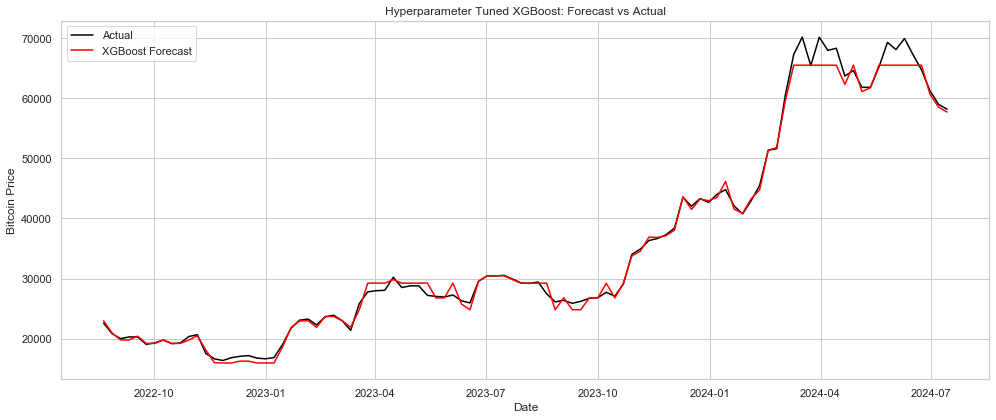

In [106]:
# Plotting
plt.figure(figsize=(14, 6))
plt.plot(y_test.index, y_test, label='Actual', color='black')
plt.plot(y_test.index, best_xgb_pred, label='XGBoost Forecast', color='red')
plt.title('Hyperparameter Tuned XGBoost: Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Bitcoin Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

XGBoost Evaluation:

XGBoost tuned using RandomizedSearchCV with TimeSeriesSplit (3 folds).

Best model found with: 300 trees, depth 6, learning rate 0.05, gamma 0.1, colsample_bytree 0.8, reg_lambda 1, subsample 1.0.

Further improved with early stopping on validation data to prevent overfitting.

Achieved excellent metrics: RMSE ≈ 1218.63, MAE ≈ 748.50, R² ≈ 0.9948.

Outperformed Random Forest individually, showing better predictive ability on unseen Bitcoin data.

# Weighted Ensemble Model

In [107]:
# Composite inverse score (average of inverse MAE and RMSE)
inv_score_rf = (1 / best_rf_rmse + 1 / best_rf_mae) / 2
inv_score_xgb = (1 / best_xgb_rmse + 1 / best_xgb_mae) / 2

# Normalize weights
total_inv_score = inv_score_rf + inv_score_xgb
rf_weight = inv_score_rf / total_inv_score
xgb_weight = inv_score_xgb / total_inv_score

# Print weights of both models
print(f"RF Weight: {rf_weight:.2f}, XGB Weight: {xgb_weight:.2f}")

# Weighted predictions
weighted_ensemble_preds = (rf_weight * best_rf_pred) + (xgb_weight * best_xgb_pred)

RF Weight: 0.41, XGB Weight: 0.59


In [108]:
# Evaluate Model Performance
weighted_ensemble_rmse = np.sqrt(mean_squared_error(y_test, weighted_ensemble_preds))
weighted_ensemble_mae = mean_absolute_error(y_test, weighted_ensemble_preds)
weighted_ensemble_r2_score = r2_score(y_test, weighted_ensemble_preds)

# Print Evaluation Metrics
print("Weighted Ensemble Model Evaluation:")
print(f"RMSE: {weighted_ensemble_rmse:.4f}")
print(f"MAE: {weighted_ensemble_mae:.4f}")
print(f"(R²) Score: {weighted_ensemble_r2_score:.4f}")

Weighted Ensemble Model Evaluation:
RMSE: 1392.9613
MAE: 778.4714
(R²) Score: 0.9932


Weighted Ensemble Evaluation:

Built by combining predictions from the best Random Forest and best XGBoost models.

Composite inverse scores (based on inverse MAE and RMSE) calculated for fair weighting.

Weights normalized: 41% Random Forest, 59% XGBoost.

Achieved robust metrics: RMSE ≈ 1392.96, MAE ≈ 778.47, R² ≈ 0.9932.

Balanced model strengths, reducing variance and improving generalization on Bitcoin price forecasting.

# Feature Importance from Weighted Ensemble Model

Feature Importance Scores:
      Feature  Importance
0        High    0.365415
2         Low    0.325593
1        Open    0.236278
4         MA4    0.036178
3        Lag1    0.031070
5        Lag2    0.005160
6        MA12    0.000220
8      Volume    0.000057
7  Volatility    0.000029


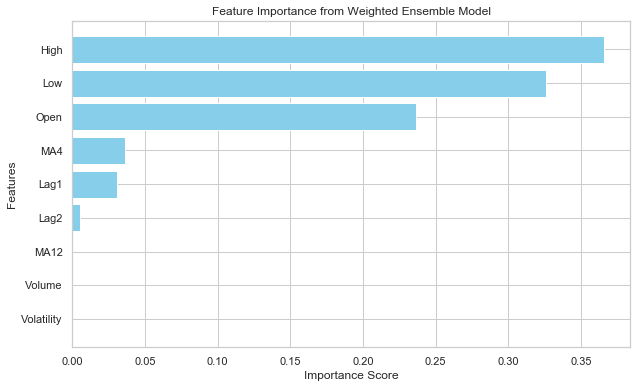

In [109]:
# Extract feature importance from the best model
rf_importances = best_rf.feature_importances_
xgb_importances = best_xgb.feature_importances_
features = X_train.columns

# Weighted average of feature importances
ensemble_importance = (rf_weight * rf_importances) + (xgb_weight * xgb_importances)

# Create a DataFrame for sorting
importance_df = pd.DataFrame({'Feature': features, 'Importance': ensemble_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print Feature Importance Scores
print("Feature Importance Scores:")
print(importance_df)

# Plot Feature Importance Chart
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance from Weighted Ensemble Model')
plt.show()